In [446]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = None


In [447]:
tables_req = ['admissions','patients','dIcdDiagnoses','dIcdProcedures','diagnoses','drgcodes','icuStays','procedures']
d={}
for x in tables_req:
        
        dataframe=pd.read_csv('C:/Users/utsavd/Downloads/50KData/{}.csv'.format(x))
        d["{}".format(x)]=dataframe

In [448]:
for x in d.keys():
    d[x].drop(['row_id'],axis=1,inplace=True)

In [449]:
drgcodes=pd.read_csv('C:/Users/utsavd/Downloads/drgcodes.csv')
drgpatients=pd.read_csv('C:/Users/utsavd/Downloads/drgPatients.csv')

In [450]:
drgpatients.drop('row_id',axis=1,inplace=True)
drgcodes.drop('row_id',axis=1,inplace=True)

In [451]:
DrgCodes=pd.concat([d['drgcodes'],drgcodes],axis=0)
DrgCodes.drop_duplicates(keep='first')
DrgCodes=DrgCodes.sort_values(by='subject_id')
drgpatients=drgpatients[drgpatients['dod'].isnull()]

In [452]:
DrgCodes=DrgCodes[['subject_id','hadm_id','drg_code','description']]
DrgCodes=DrgCodes.reset_index(drop=True)

In [453]:
d['admissions']=d['admissions'][['subject_id','hadm_id','insurance','admission_type','diagnosis','admittime','dischtime','insurance']]
d['patients']=d['patients'][['dob','subject_id']]

In [454]:
df=pd.merge(d['admissions'],d['patients'],on=['subject_id'],how='left')

In [455]:
df['timeofstay']=pd.to_datetime(df['dischtime'])-pd.to_datetime(df['admittime'])

In [456]:
df['timeofstay']=df['timeofstay'].dt.days

In [457]:
df['age']=pd.to_datetime(df['admittime'])-pd.to_datetime(df['dob'])
df.drop('dob',axis=1,inplace=True)
df['age']=(df['age'].dt.days)/365
df['age']=df['age'].astype(int)

In [458]:
def is_emergency(x):
    if x=='EMERGENCY':
        return 1
    else:
        return 0
df['emergency']=df['admission_type'].apply(is_emergency)

In [459]:
df.admittime=pd.to_datetime(df.admittime)
df.dischtime=pd.to_datetime(df.dischtime)

In [460]:
df=df.sort_values(['subject_id','admittime'])
df=df.sort_values(['subject_id','dischtime'])
df=df.reset_index(drop=True)

In [461]:
df.drop(['admission_type'],axis=1,inplace=True)
df=df.reset_index(drop=True)

In [462]:
df['readmitted']=df.groupby('subject_id').cumcount()

In [463]:
df=df[df['age']>=0]

In [464]:
df['readmitted']=df['readmitted'].shift(-1)
df['readmitted']=df['readmitted'].fillna(0)
df['readmitted']=df['readmitted'].astype(int)

In [465]:
df=df.reset_index(drop=True)

In [466]:
df=df[['readmitted', 'subject_id', 'emergency','hadm_id', 'insurance',
       'timeofstay', 'age', 'diagnosis', 'admittime', 'dischtime'
       ]]

In [467]:
df = df.loc[:,~df.columns.duplicated()]

In [468]:
def calc_read_within_6(test):
    test=test.reset_index(drop=True)
    test['total_em_6']=np.zeros(test.shape[0])
    for x in range(1,test.shape[0]):
        for j in range(0,x):
            a=(test.loc[x,'admittime']-test.loc[j,'dischtime']).days
            if a<365 and test.loc[j,'emergency']==1:
                test.loc[x,'total_em_6']=test.loc[x,'total_em_6']+1
    return test

In [469]:
gp = df.groupby('subject_id')   
df1=pd.DataFrame(columns=['subject_id','emergency','admittime','dischtime'])
reoccuring_ids=list(df['subject_id'].value_counts()[df['subject_id'].value_counts()>1].index)
for x in reoccuring_ids:
    a=gp.get_group(x)[['subject_id','emergency','admittime','dischtime']]
    df1=pd.concat([df1,calc_read_within_6(a)],axis=0)

df1=df1.sort_values(by='subject_id')[['subject_id','admittime','total_em_6']]
df=pd.merge(df,df1,on=['subject_id','admittime'],how='left')
df['total_em_6'].fillna(0,inplace=True)

In [470]:
comorbid=list(drgcodes[drgcodes['description'].str.contains(' CC| MCC')]['subject_id'])

In [471]:
comorbid.sort()

In [472]:
for x in range(0,df.shape[0]):
    if df.loc[x,'subject_id'] in comorbid:
        df.loc[x,'comorbid']=1
    else:
        df.loc[x,'comorbid']=0

In [473]:
diagnoses=pd.read_csv('C:/Users/utsavd/Downloads/diagnoses.csv')

diagnoses.drop(['row_id','seq_num'],axis=1,inplace=True)

diagnoses=diagnoses.sort_values(by='subject_id')

In [474]:
df2=pd.merge(df,diagnoses,on=['subject_id','hadm_id'],how='left')

In [475]:
#Charlson's Comorbidity Points Converter
def points_tally(x):
    if x.startswith(('2500','428','410','490','491','492','493','494','495','496','4439','436','43310','290','294','331','710','533')):
        return 1
    elif x.startswith(('2504','2505','2506','2507','2509','342','5853','5854','5855','5856','571','202','204','205','206','207','208')):
        return 2
    elif x.startswith('042'):
        return 5
    elif x.startswith(('190','191','192','193','194','195','196','197','198','199')):
        return 6
    else:
        return 0

In [476]:
df2['icd9_code']=df2['icd9_code'].astype(str)
df2['icd9_code']=df2['icd9_code'].apply(points_tally)

In [477]:
df=pd.merge(df,df2.groupby(['subject_id','hadm_id'])['icd9_code'].sum().reset_index(),on=['subject_id','hadm_id'],how='left')

In [478]:
#df.drop(['diagnosis'],axis=1,inplace=True)

In [479]:
for x in range(0,df.shape[0]):
    if df.loc[x,'readmitted']>0:
        df.loc[x,'t_read']=df.loc[x+1,'admittime']-df.loc[x,'dischtime']        

In [480]:
df['t_read']=df['t_read'].dt.days

In [481]:
def classify_for_readmits_within_30(x):
    if x['readmitted']>0 and x['t_read']<30.0:
        return 1
    else:
        return 0

In [482]:
df.readmitted=df.apply(classify_for_readmits_within_30,axis=1)

In [483]:
df['CHRONIC']=np.where(df['diagnosis'].str.contains('CHRONIC',na=False),1,0)

In [486]:
df.fillna(0,inplace=True)

In [487]:
icu=d['icuStays'][['subject_id','outtime']]
icu['outtime']=pd.to_datetime(icu['outtime'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [489]:
def insurance_class(x):
    if x == 'Medicare' or x == 'Medicaid':
        return 1
    else:
        return 0

In [490]:
df['insurance']=df['insurance'].apply(insurance_class)

In [491]:
import seaborn as sns
import matplotlib.pyplot as plt

In [492]:
input_data=df.drop(['subject_id','hadm_id','admittime','dischtime','diagnosis','t_read'],axis=1)

In [493]:
input_data.total_em_6=input_data['total_em_6'].astype(int)
input_data.comorbid=input_data.comorbid.astype(int)

# Model Building

In [494]:
import collections

In [495]:
from sklearn.model_selection import train_test_split

In [496]:
x=input_data.drop(['readmitted'],axis=1)
y=input_data['readmitted']

In [440]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
x=scaler.fit_transform(x)

In [441]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y , test_size=0.2)

In [442]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, Y_sm = smote.fit_sample(X_train,Y_train)
X_final, Y_final = smote.fit_sample(X_sm,Y_sm)
X_train=X_final
Y_train=Y_final

In [443]:
from sklearn.linear_model import LogisticRegression
LogReg = LogisticRegression(penalty='l1',max_iter=1000)
LogReg.fit(X_train, Y_train)
Y_pred = LogReg.predict(X_test)
print('Accuracy:',LogReg.score(X_test,Y_test).round(2)*100,'%')

Accuracy: 67.0 %


In [438]:
list(zip(LogReg.coef_.ravel().round(2).tolist(),list(input_data.drop('readmitted',axis=1))))

[(0.23, 'emergency'),
 (0.27, 'insurance'),
 (3.26, 'timeofstay'),
 (0.23, 'age'),
 (10.89, 'total_em_6'),
 (0.36, 'comorbid'),
 (0.83, 'icd9_code'),
 (-0.17, 'CHRONIC')]

In [429]:
import pickle
pickle.dump(LogReg, open('interface.sav', 'wb'))

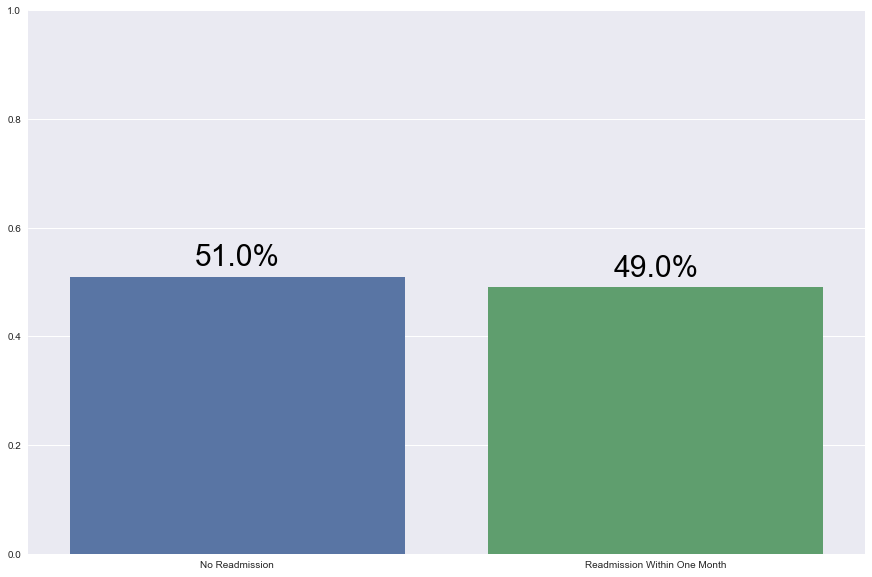

In [268]:
sns.set()
plt.figure(figsize=(15,10))
ax=sns.barplot(y=l,x=['No Readmission','Readmission Within One Month'])
plt.ylim(0,1)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
    p.get_height()+0.02,
    '{:1.1f}%'.format(height*100),
    ha="center",color='black',fontsize=30)

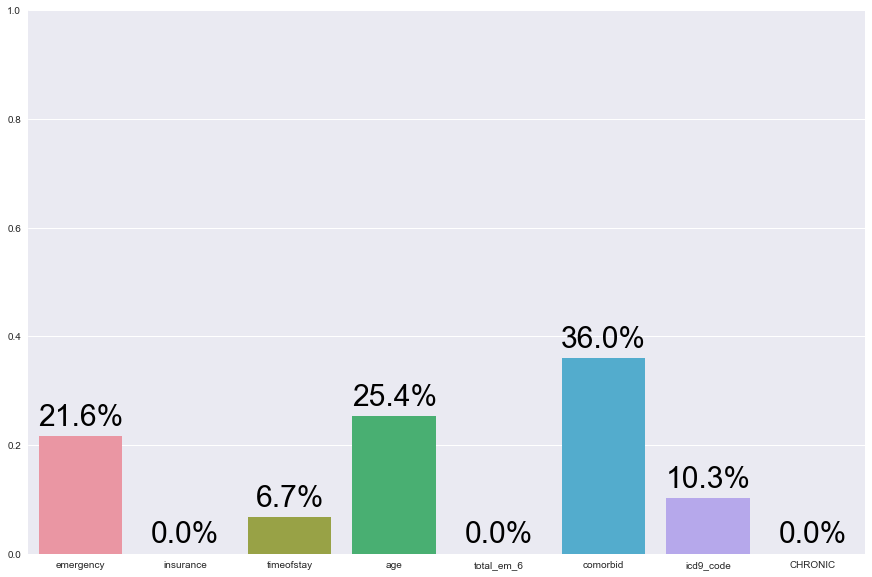

In [339]:
a=list(LogReg.coef_.round(2).ravel())
b=list(X_test[3].round(2))

factors=[0,0,0,0,0,0,0,0]
for x in range(0,len(list(LogReg.coef_.round(2).ravel()))):
    factors[x]=a[x]*b[x]

s = sum(factors); norm = [float(i)/s for i in factors]

sns.set()
plt.figure(figsize=(15,10))
ax=sns.barplot(y=norm,x=list(input_data.drop('readmitted',axis=1)))
plt.ylim(0,1)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
    p.get_height()+0.02,
    '{:1.1f}%'.format(height*100),
    ha="center",color='black',fontsize=30)

In [153]:
pd.crosstab(Y_pred,Y_test,normalize='columns').round(2)

readmitted,0,1
row_0,,
0,0.65,0.43
1,0.35,0.57


In [151]:
pd.crosstab(Y_pred,Y_test,normalize='index').round(2)

readmitted,0,1
row_0,,
0,0.96,0.04
1,0.91,0.09


In [155]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, Y_pred)

0.6070063575877876

In [156]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

mlp.fit(X_train,Y_train)
Y_pred = mlp.predict(X_test)

In [157]:
mlp.score(X_test,Y_test)

0.876619306310071

In [158]:
pd.crosstab(Y_pred,Y_test)

readmitted,0,1
row_0,,
0,8253,436
1,745,138


In [58]:
from sklearn.linear_model import SGDClassifier

In [59]:
sgd=SGDClassifier(alpha=0.1,class_weight='balanced')
sgd.fit(X_train,Y_train)
Y_pred=sgd.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [61]:
pd.crosstab(Y_pred,Y_test,normalize='columns').round(2)

readmitted,0,1
row_0,,
0,0.5,0.31
1,0.5,0.69


In [83]:
sgd.score(X_test,Y_test)

0.5094024237358964

In [63]:
from sklearn.metrics import classification_report 

In [64]:
print(classification_report(Y_pred,Y_test))

             precision    recall  f1-score   support

          0       0.50      0.97      0.66      4677
          1       0.69      0.07      0.13      4895

avg / total       0.60      0.51      0.39      9572



In [66]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier()
model.fit(X_train, Y_train)
Y_pred=model.predict(X_test)
accuracy_score(Y_pred,Y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9358545758462181

In [67]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, Y_pred)

0.5375031373927011

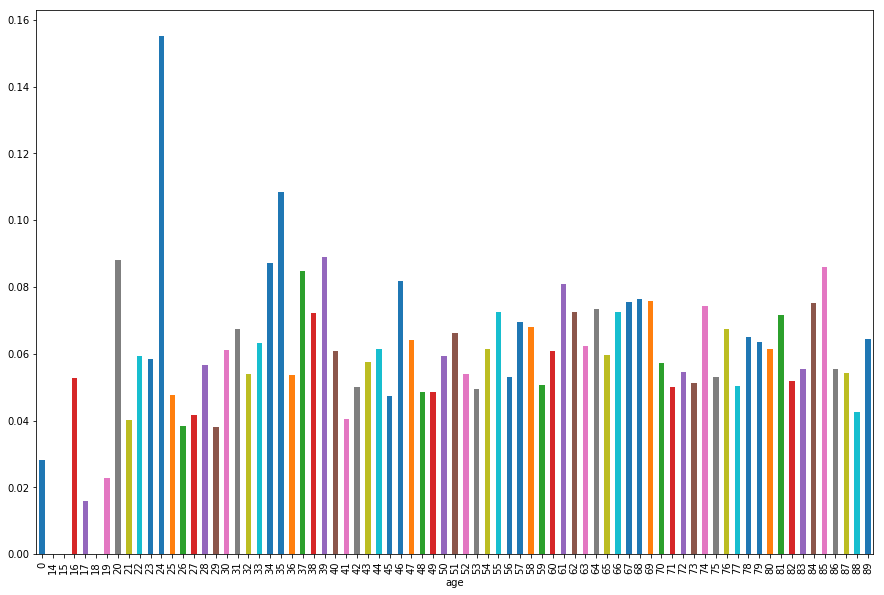

In [68]:
plt.figure(figsize=(15,10))
df.groupby('age')['readmitted'].mean().plot.bar()

In [69]:
pd.crosstab(Y_pred,Y_test)

readmitted,0,1
row_0,,
0,8911,470
1,144,47


In [70]:
from sklearn.neighbors import KNeighborsClassifier
## Instantiate the model with 5 neighbors. 
knn = KNeighborsClassifier(weights='distance')
## Fit the model on the training data.
knn.fit(X_train, Y_train)
## See how the model performs on the test data.
knn.score(X_test, Y_test)

0.8882156289176766

In [71]:
Y_pred=knn.predict(X_test)

In [72]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, Y_pred)

0.5451520740969381

In [73]:
from sklearn.svm import SVC
svc = SVC(class_weight='balanced')
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_test,Y_test), 3)
acc_svc

0.888

In [74]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, Y_pred)

0.5761566699099743

In [76]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)

In [77]:
tree.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=28,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [78]:
tree.score(X_test,Y_test)

0.9022147931466779

In [81]:
roc_auc_score(Y_pred,Y_test)

0.5515668312410189

In [82]:
pd.crosstab(Y_test,Y_pred)

col_0,0,1
readmitted,,
0,8385,670
1,400,117


In [102]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(class_weight='balanced')
forest.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [103]:
forest.score(X_test,Y_test)

0.8957375679063937

In [95]:
Y_pred=forest.predict(X_test)

In [104]:
pd.crosstab(Y_pred,Y_test,normalize='columns')

readmitted,0,1
row_0,,
0,0.833686,0.825043
1,0.166314,0.174957
